# Setup

In [1]:
import scanpy as sc
import numpy as np
import re
import os
import pandas as pd
import seaborn as sb
import matplotlib
import scipy.sparse as sp
from scipy.sparse import issparse
import anndata2ri

import matplotlib as mpl
from scipy import stats as scistats
import matplotlib.pyplot as pl
import scanpy.external as sce
from matplotlib import colors
import bbknn
from pathlib import Path
from ipywidgets import interactive

sc._settings.ScanpyConfig.n_jobs=8

pl.rcParams['pdf.fonttype'] = 'truetype'
sc.set_figure_params(vector_friendly=False,dpi_save=300,transparent=True)
pl.rcParams['lines.linewidth'] = 0.1
sc.set_figure_params(color_map='viridis')
colorsComb = np.vstack([pl.cm.Reds(np.linspace(0, 1, 10)), pl.cm.Greys_r(np.linspace(0.7, 0.8, 0))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

import muon as mu
from muon import prot as pt

%matplotlib inline
import panel as pn
#pn.extension(sizing_mode="stretch_width", comms='colab')
pn.extension( comms='colab')


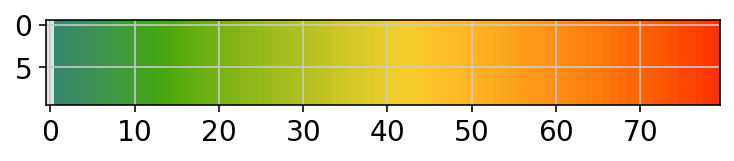

In [2]:
import colorcet as cc

xs, _ = np.meshgrid(np.linspace(0, 1, 80), np.linspace(0, 1, 10))
colorsComb = np.vstack([pl.cm.Greys_r(np.linspace(0.8,0.1, 1)), cc.cm.rainbow_bgyr_35_85_c72(np.linspace(0.2,1, 100))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
pl.imshow(xs, cmap=mymap);  # use tab completion to choose

In [3]:
# add extra code to the path
import sys
sys.path.append('/content/sctoolkit/sctoolkit/')
from proportions import *

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.


In [4]:
%load_ext watermark
%watermark
%watermark --iversions -v -m -p numpy,scipy,sklearn,anndata,scanpy,muon,anndata2ri,rpy2

Last updated: 2022-06-27T21:33:20.560581+00:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.0.1

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.13.0-1031-aws
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.0.1

numpy     : 1.21.5
scipy     : 1.7.3
sklearn   : 0.0
anndata   : 0.7.8
scanpy    : 1.9.1
muon      : 0.1.2
anndata2ri: 1.0.6
rpy2      : 3.4.5

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.13.0-1031-aws
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

sys       : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]
scanpy    : 1.9.1
panel     : 0.13.1
matplotlib: 3.5.1
numpy     : 1.21.5
anndata2ri: 1.0.6
muon      : 0.1.2
logging   : 0.5.1.2
re        : 2.2.1
colorcet  : 3.0.0
seaborn   : 0.11.2
pandas    : 1.2.5
bbknn     : 1.5.1
scipy    

# Download PBMC data from 10X

In [5]:
data_dir = '/home/jovyan/work/public-data/data/multiomics/'
! pwd

/home/jovyan/work/multiomics


# Setup WD

In [6]:
#Change XXX to sample name
#folder='/content/'
samplename='PBMC_granulocyte_sorted'
random_state=42

import os

if not os.path.exists('./figures/'):
    os.makedirs('./figures/')

# import data as H5AD

In [7]:
mdata = mu.read_10x_h5(data_dir + "/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5")
mdata.var_names_make_unique()
mdata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added `interval` annotation for features from /home/jovyan/work/public-data/data/multiomics//pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/conda/lib/python3.9/site-packages/mudata/_core/mudata.py:405: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.


MuData object with n_obs × n_vars = 11909 × 144978
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	11909 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	11909 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

In [8]:
mdata.obs['sample']=[samplename]*mdata.n_obs
mdata.obs['group']=[samplename]*mdata.n_obs

In [9]:
rna = mdata.mod['rna']

rna.obs['sample']=[samplename]*rna.n_obs
rna.obs['group']=[samplename]*rna.n_obs
rna

AnnData object with n_obs × n_vars = 11909 × 36601
    obs: 'sample', 'group'
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [10]:
sc.pp.filter_genes(rna, min_cells=10)
rna

AnnData object with n_obs × n_vars = 11909 × 22020
    obs: 'sample', 'group'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells'

In [11]:
# Quality control - calculate QC covariates
rna.obs['n_counts'] = rna.X.sum(1)
rna.obs['log_counts'] = np.log(rna.obs['n_counts'])
rna.obs['n_genes'] = (rna.X > 0).sum(1)

# compute qc metrics

rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
rna.var['rb'] = rna.var_names.str.startswith(('RPS','RPL'))  # annotate the group of ribosomal proteins as 'rb'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(rna, qc_vars=['rb'], percent_top=None, log1p=False, inplace=True)

rna

AnnData object with n_obs × n_vars = 11909 × 22020
    obs: 'sample', 'group', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

# Filter doublets with scrublet

In [12]:
sce.pp.scrublet(rna,
    adata_sim = None,
    sim_doublet_ratio= 2.0,
    expected_doublet_rate = 0.05,
    stdev_doublet_rate = 0.02,
    synthetic_doublet_umi_subsampling= 1.0,
    knn_dist_metric = 'euclidean',
    normalize_variance= True,
    log_transform= False,
    mean_center= True,
    n_prin_comps= 30,
    use_approx_neighbors= True,
    get_doublet_neighbor_parents= False,
    n_neighbors = None,
    threshold = None,
    verbose = True,
    copy= False,
random_state= 0,)

/opt/conda/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.


Automatically set threshold at doublet score = 0.15
Detected doublet rate = 9.0%
Estimated detectable doublet fraction = 67.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 13.4%


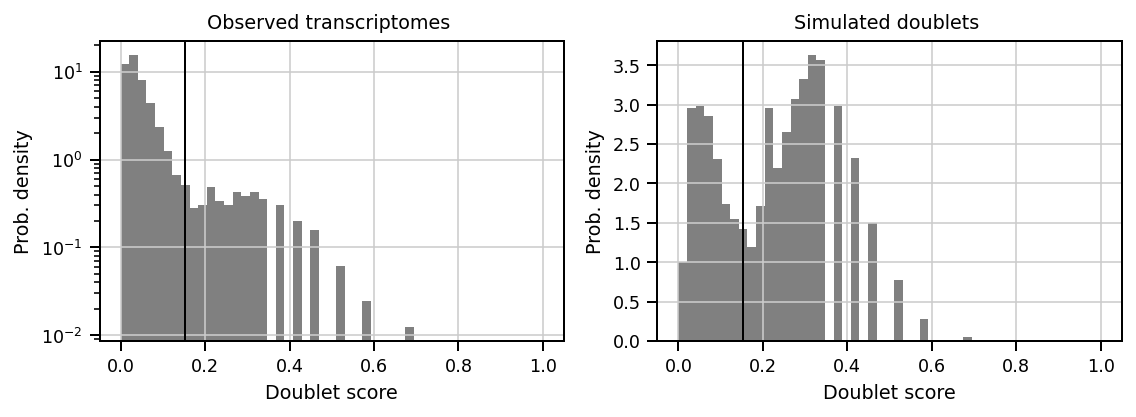

In [13]:
sb.set_context('paper')
savefig=samplename + '_7_QC_doublets.pdf'
sce.pl.scrublet_score_distribution(rna,save=savefig)

# Helper plots for determining gene and count threshold values

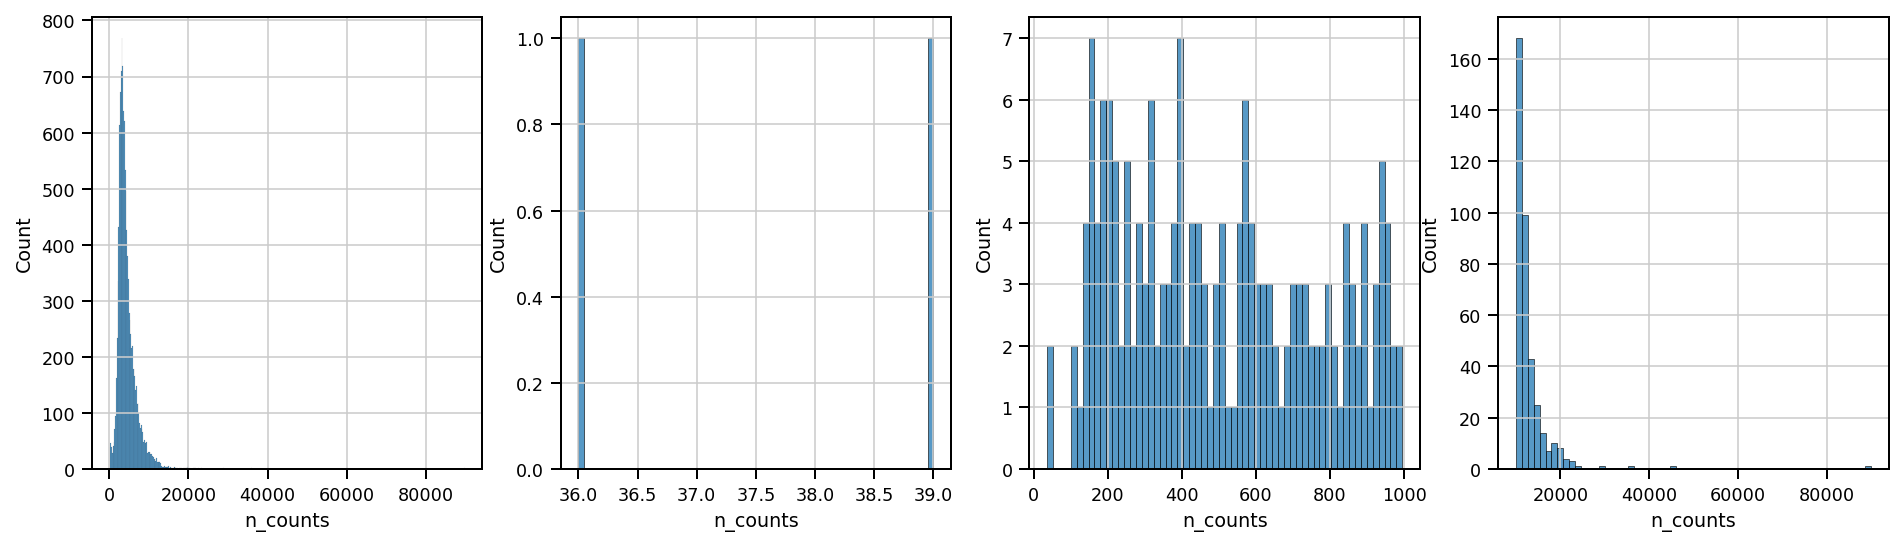

In [14]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sb.histplot(rna.obs['n_counts'], kde=False, ax=ax1,)
ax2_dict =  sb.histplot(rna.obs['n_counts'][rna.obs['n_counts']<100], kde=False, bins=60, ax=ax2,)
ax3_dict =  sb.histplot(rna.obs['n_counts'][rna.obs['n_counts']<1000], kde=False, bins=60, ax=ax3,)
ax4_dict = sb.histplot(rna.obs['n_counts'][rna.obs['n_counts']>10000], kde=False, bins=60, ax=ax4, )
savefig='figures/'+samplename + '_1_QC_counts_filtering.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

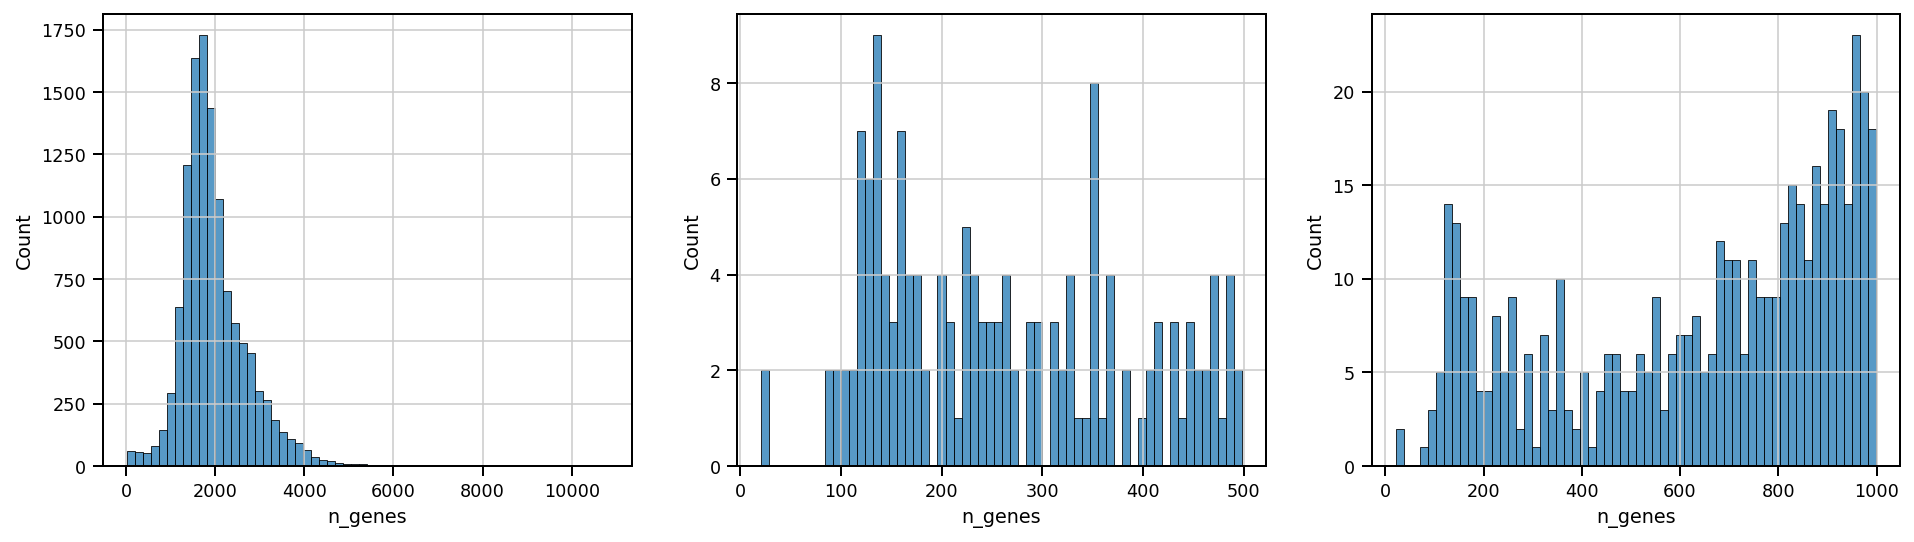

In [15]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sb.histplot(rna.obs['n_genes'], kde=False, bins=60, ax=ax1,)
ax2_dict =  sb.histplot(rna.obs['n_genes'][rna.obs['n_genes']<500], kde=False, bins=60, ax=ax2,)
ax3_dict =  sb.histplot(rna.obs['n_genes'][rna.obs['n_genes']<1000], kde=False, bins=60, ax=ax3,)
savefig='figures/'+samplename + '_2_QC_gene_filtering.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

... storing 'sample' as categorical
... storing 'group' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'interval' as categorical


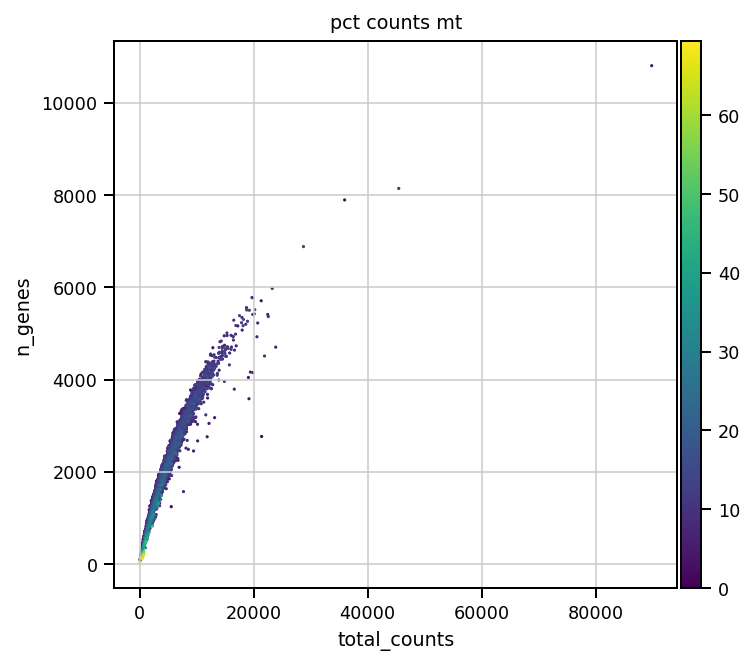

In [16]:
# plot percentage of mitochondtial genes versus count depth and n_genes
sb.set_context('paper')
pl.rcParams['figure.figsize']=(5,5) #rescale figures
savefig=samplename + '_4_QC_saturationplot.pdf'
sc.pl.scatter(rna, x='total_counts', y='n_genes', color='pct_counts_mt',save=savefig)

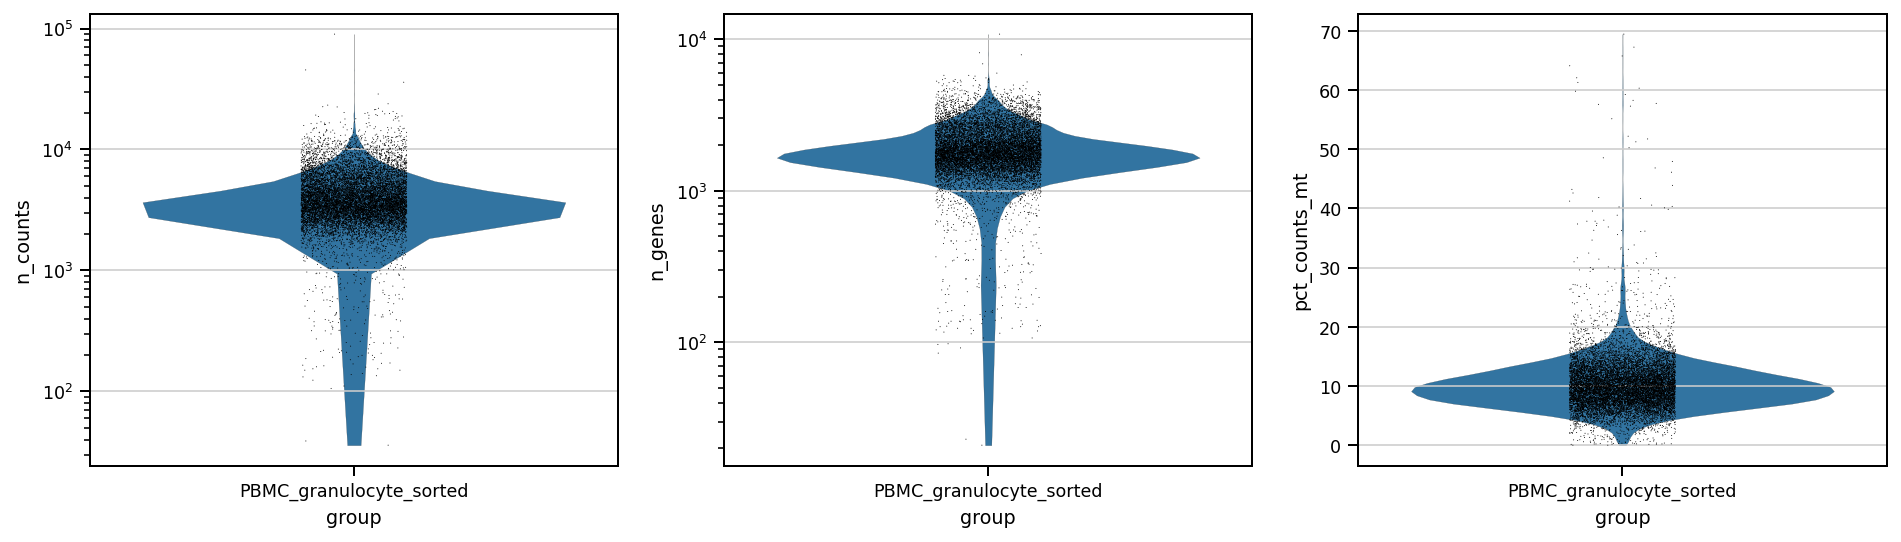

In [17]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sc.pl.violin(rna, 'n_counts', groupby='group', size=0.5, log=True, cut=0, ax=ax1, show=False)
ax2_dict =  sc.pl.violin(rna, 'n_genes', groupby='group', size=0.5, log=True, cut=0, ax=ax2, show=False)
ax3_dict = sc.pl.violin(rna, 'pct_counts_mt', groupby='group',size=0.5, ax=ax3, show=False,)
savefig='figures/'+samplename + '_5_QC_violin_plots.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

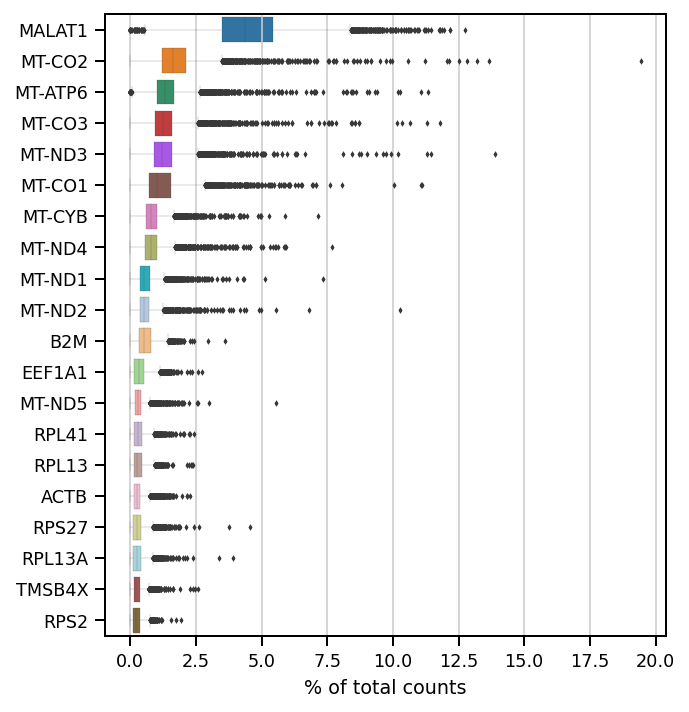

In [18]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
savefig='_'+samplename + '_6_QC_highest_expr_genes.pdf'
sc.pl.highest_expr_genes(rna, n_top=20,save=savefig,)

In [19]:
print(rna.obs['group'].value_counts())

PBMC_granulocyte_sorted    11909
Name: group, dtype: int64


In [20]:
rna.obs['n_counts'].sum()/rna.obs['group'].value_counts()

PBMC_granulocyte_sorted    4399.776304
Name: group, dtype: float64

In [21]:
rna.obs['n_counts'].sum()

52396936.0

In [22]:
def h(counts=400, genes=400,mito=15):
    conditions = [(rna.obs['predicted_doublet'] == True),(rna.obs['n_genes_by_counts'] < counts),(rna.obs['n_genes'] < genes),(rna.obs['pct_counts_mt'] >mito),(rna.obs['pct_counts_mt'] <= mito) & (rna.obs['n_genes_by_counts'] >= counts) & (rna.obs['n_genes'] >= genes)& (rna.obs['predicted_doublet'] != True)]
    values = ['Doublet', 'Low_nFeature', 'Low_ngenes','High_MT', 'Passing']
    rna.obs['QC'] = np.select(conditions, values)
    rna.obs['QC'] = rna.obs['QC'].astype('category')

    new_df1=pd.DataFrame(rna.obs['QC'].value_counts()).reset_index()
    p=sb.barplot(x='index',y='QC',data=new_df1,color='sandybrown')
    show_values(p)


interactive_plot = interactive(h, counts=(0, 2000,20), genes=(0, 2000,20), mito=(0, 100, 1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=400, description='counts', max=2000, step=20), IntSlider(value=400, desc…

In [23]:
rna.obs['QC'].value_counts()

Passing         9738
Doublet         1076
High_MT          998
Low_nFeature      97
Name: QC, dtype: int64

## Plot QC for cells that pass tentative thresholds

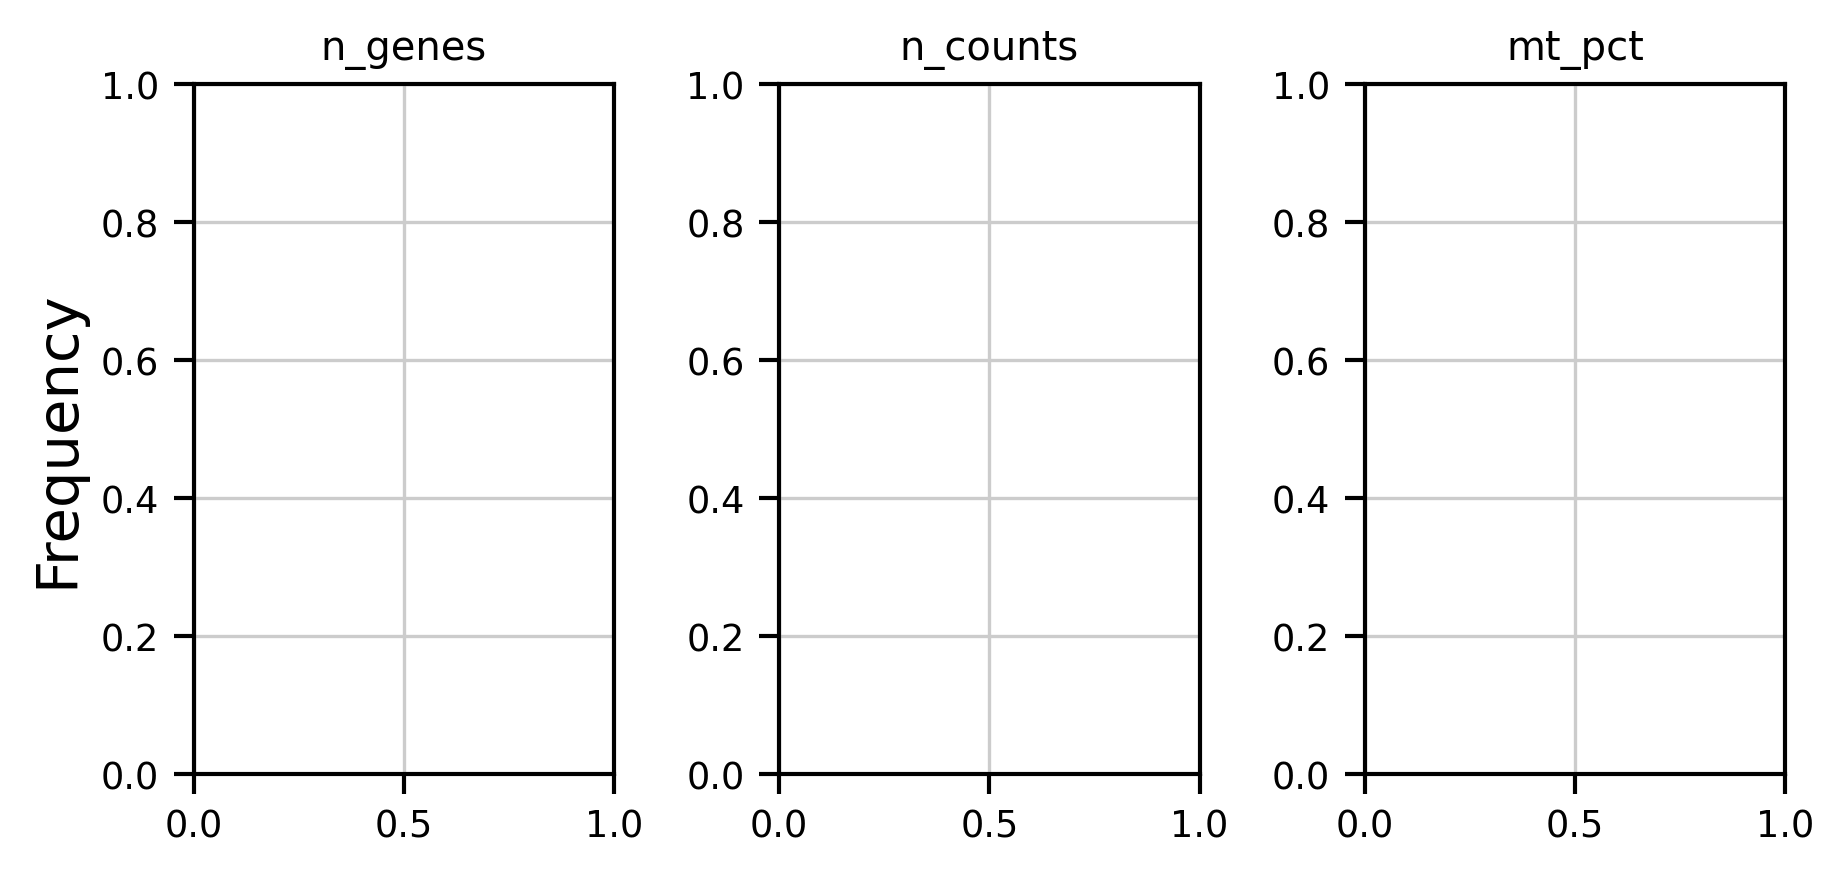

In [24]:

sb.set_context('paper')


fig, (ax1, ax2, ax3) = pl.subplots(1, 3, figsize=(6, 3), dpi=150, sharey=False)
rna.obs['n_genes']

sb.histplot( rna[rna.obs['QC'] == 'Pass'].obs['n_genes'], ax=ax1, kde=True, bins=100)
sb.histplot( rna[rna.obs['QC'] == 'Pass'].obs['n_counts'], ax=ax2, kde=True, bins=100)
sb.histplot(rna[rna.obs['QC'] == 'Pass'].obs['pct_counts_mt'], ax=ax3, kde=True, bins=100)

ax1.title.set_text('n_genes')
ax2.title.set_text('n_counts')
ax3.title.set_text('mt_pct')

fig.text(0.00, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()
savefig='figures/'+samplename + '_3_QC_filtering_postfilter.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

# Nomalization

In [25]:
rna.layers["raw"] = rna.X 
rna.raw=rna
rna.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(rna, inplace=False)["X"])

In [26]:
sc.experimental.pp.recipe_pearson_residuals(rna,n_top_genes=3000,n_comps=100,random_state=42,inplace=True)
rna.layers["normalized"]=rna.X
sc.pp.log1p(rna)
rna.layers["logcounts"] = rna.X

rna

AnnData object with n_obs × n_vars = 11909 × 22020
    obs: 'sample', 'group', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'doublet_score', 'predicted_doublet', 'QC'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'scrublet', 'group_colors', 'hvg', 'pca', 'pearson_residuals_normalization', 'log1p'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw', 'sqrt_norm', 'normalized', 'logcounts'

# cellcycle score

In [27]:
s_genes = ['MCM5','PCNA','TYMS','FEN1','MCM7','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1',
           'UHRF1','CENPU','HELLS','RFC2','POLR1B','NASP','RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7',
           'POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2',
           'USP1','CLSPN','POLA1','CHAF1B','MRPL36','E2F8']
g2m_genes = ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B',
             'MKI67','TMPO','CENPF','TACC3','PIMREG','SMC4','CCNB2','CKAP2L','CKAP2','AURKB','BUB1',
             'KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','CDCA3','JPT1','CDC20','TTK','CDC25C',
             'KIF2C','RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1',
             'ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3','CBX5','CENPA']
cell_cycle_genes = s_genes + g2m_genes
display(len(s_genes))
display(len(g2m_genes))
display(len(cell_cycle_genes))

43

54

97

In [28]:
cell_cycle_genes = [x for x in cell_cycle_genes if x in rna.var_names]
len(cell_cycle_genes)

96

In [29]:
sc.tl.score_genes_cell_cycle(rna, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


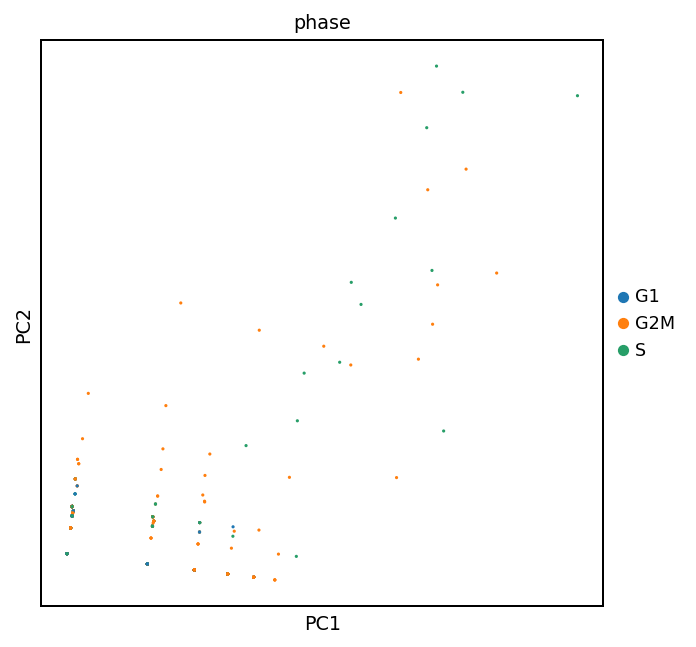

In [30]:
adata_cc_genes = rna[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

# PCA

In [31]:
#sc.pp.scale(rna,max_value=10)

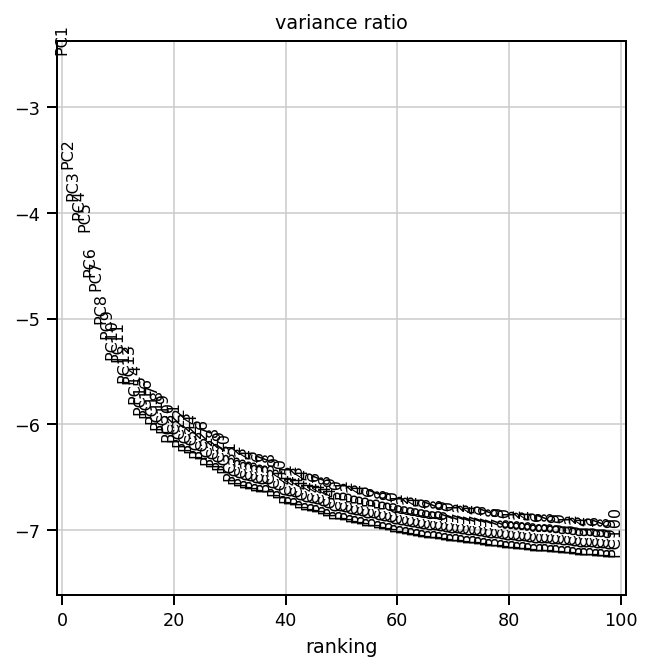

In [32]:
#sc.pp.pca(rna, n_comps = 100, use_highly_variable =False, svd_solver = "arpack")
sc.pl.pca_variance_ratio(rna, n_pcs = 100,log=True)

... storing 'phase' as categorical


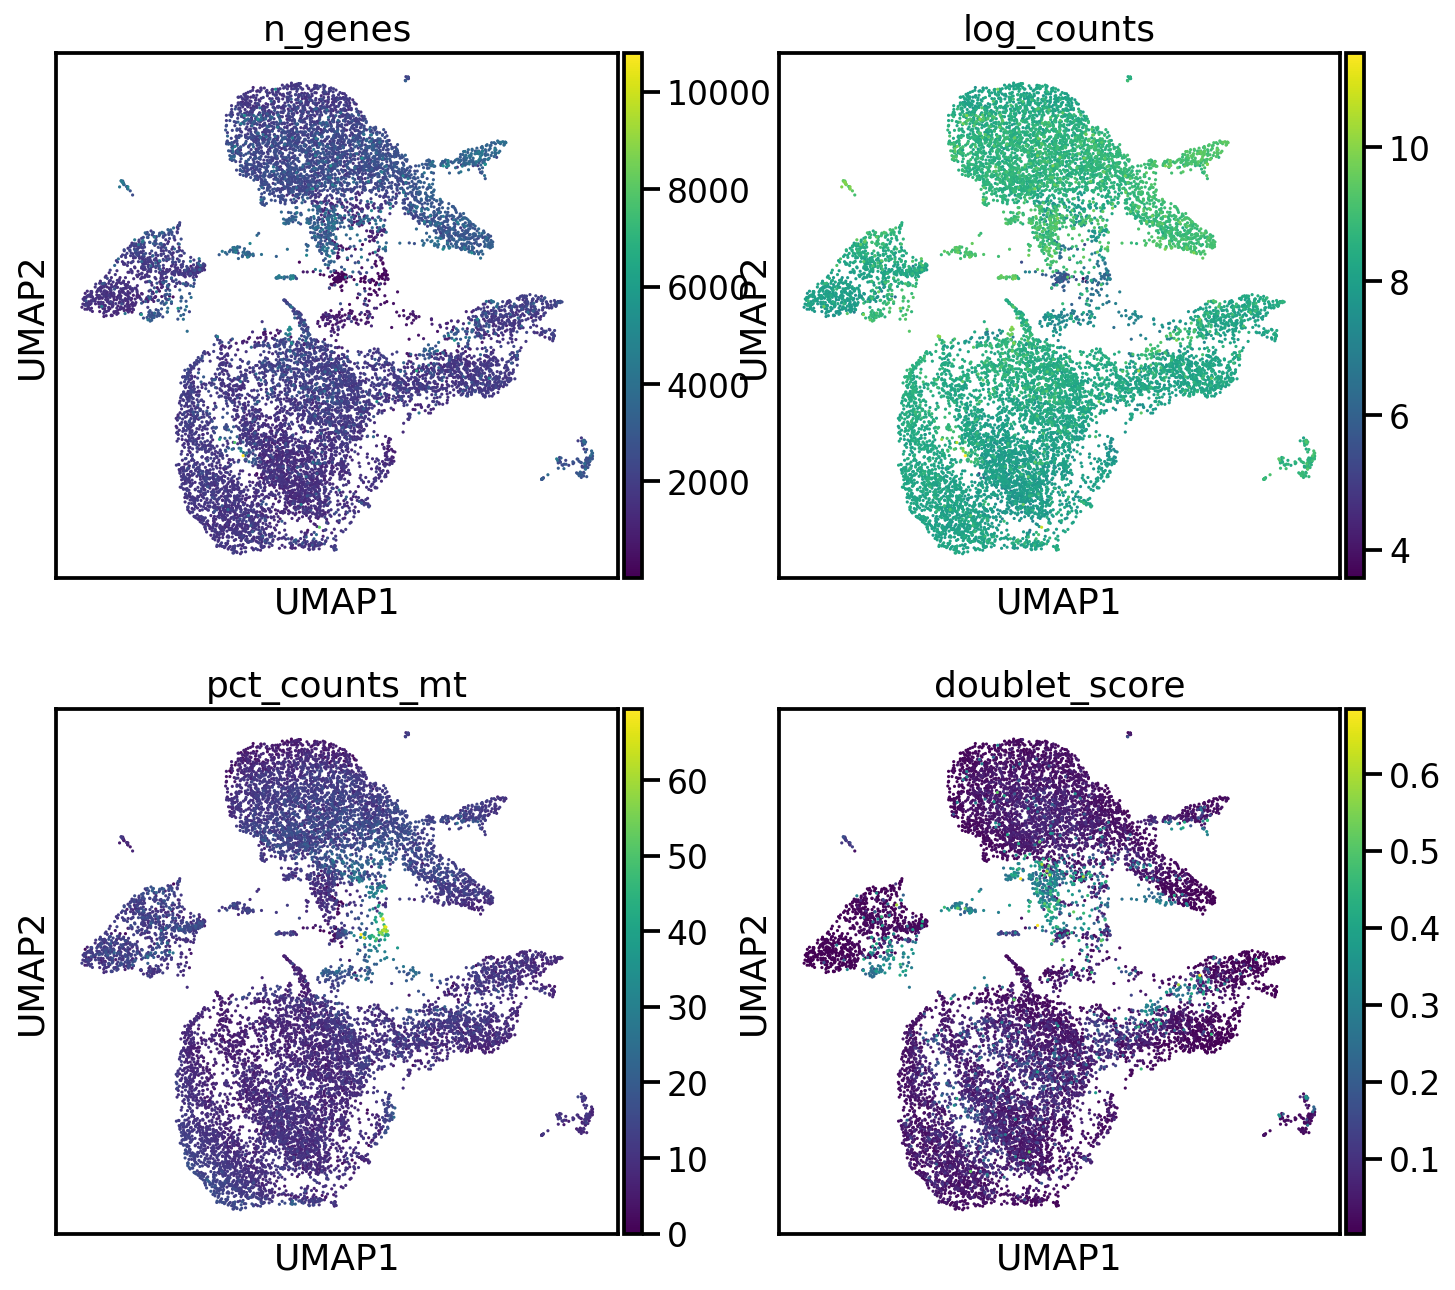

In [33]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
sc.pp.neighbors(rna, n_pcs=30,n_neighbors=10,random_state=42)
#bbknn.bbknn(rna,batch_key = "donnor", neighbors_within_batch =10, n_pcs = 50)
#Save to figures (not sample specific folder)
genes_to_plot = ['n_genes','log_counts','pct_counts_mt','doublet_score']
#sc.tl.tsne(rna, n_jobs=8,use_rep='X', perplexity=30) 
sc.tl.umap(rna,random_state=42)
savefig=samplename+"_4_QC_doublets_vst_mito.pdf"
sc.pl.umap(rna, color = genes_to_plot,ncols=2,save=savefig)

In [34]:
rna

AnnData object with n_obs × n_vars = 11909 × 22020
    obs: 'sample', 'group', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'doublet_score', 'predicted_doublet', 'QC', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'scrublet', 'group_colors', 'hvg', 'pca', 'pearson_residuals_normalization', 'log1p', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'sqrt_norm', 'normalized', 'logcounts'
    obsp: 'distances', 'connectivities'

In [35]:
rna = rna[rna.obs['QC'] == 'Passing']
rna

View of AnnData object with n_obs × n_vars = 9738 × 22020
    obs: 'sample', 'group', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'doublet_score', 'predicted_doublet', 'QC', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'scrublet', 'group_colors', 'hvg', 'pca', 'pearson_residuals_normalization', 'log1p', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'sqrt_norm', 'normalized', 'logcounts'
    obsp: 'distances', 'connectivities'

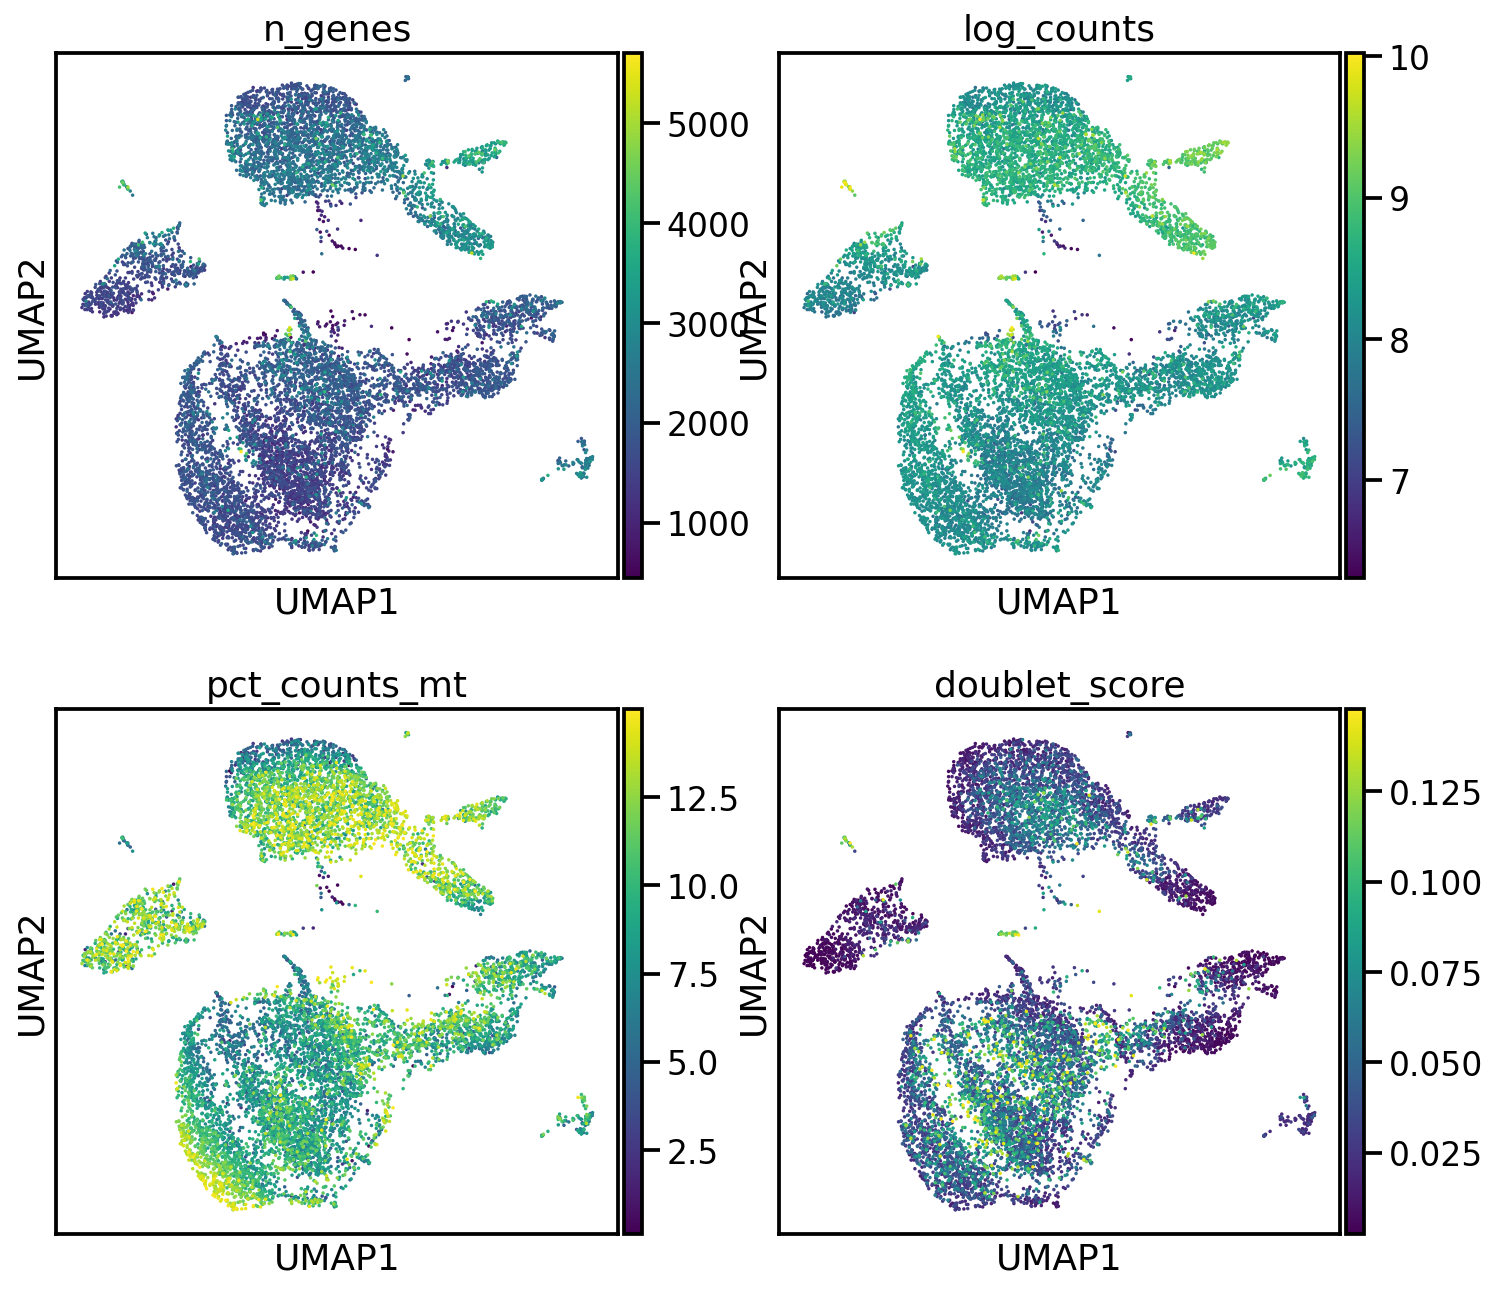

In [36]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
savefig=samplename+"_4_QC_doublets_vst_mito.pdf"
sc.pl.umap(rna, color = genes_to_plot,ncols=2,save=savefig)

In [37]:
rna.shape[0]

9738

# Re-analyse the data only with cells passing QC

In [38]:
rna.X=rna.layers['raw']

In [39]:
# Nomalization
rna.layers["raw"] = rna.X 
rna.raw=rna
rna.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(rna, inplace=False)["X"])

sc.experimental.pp.recipe_pearson_residuals(rna,n_top_genes=3000,n_comps=100,random_state=42,inplace=True)
rna.layers["normalized"]=rna.X
sc.pp.log1p(rna)
rna.layers["logcounts"] = rna.X

rna

/opt/conda/lib/python3.9/site-packages/scanpy/experimental/pp/_highly_variable_genes.py:73: UserWarning: `flavor='pearson_residuals'` expects raw count data, but non-integers were found.
/opt/conda/lib/python3.9/site-packages/scanpy/experimental/pp/_normalization.py:43: UserWarning: `normalize_pearson_residuals()` expects raw count data, but non-integers were found.


AnnData object with n_obs × n_vars = 9738 × 22020
    obs: 'sample', 'group', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'doublet_score', 'predicted_doublet', 'QC', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'scrublet', 'group_colors', 'hvg', 'pca', 'pearson_residuals_normalization', 'log1p', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'sqrt_norm', 'normalized', 'logcounts'
    obsp: 'distances', 'connectivities'

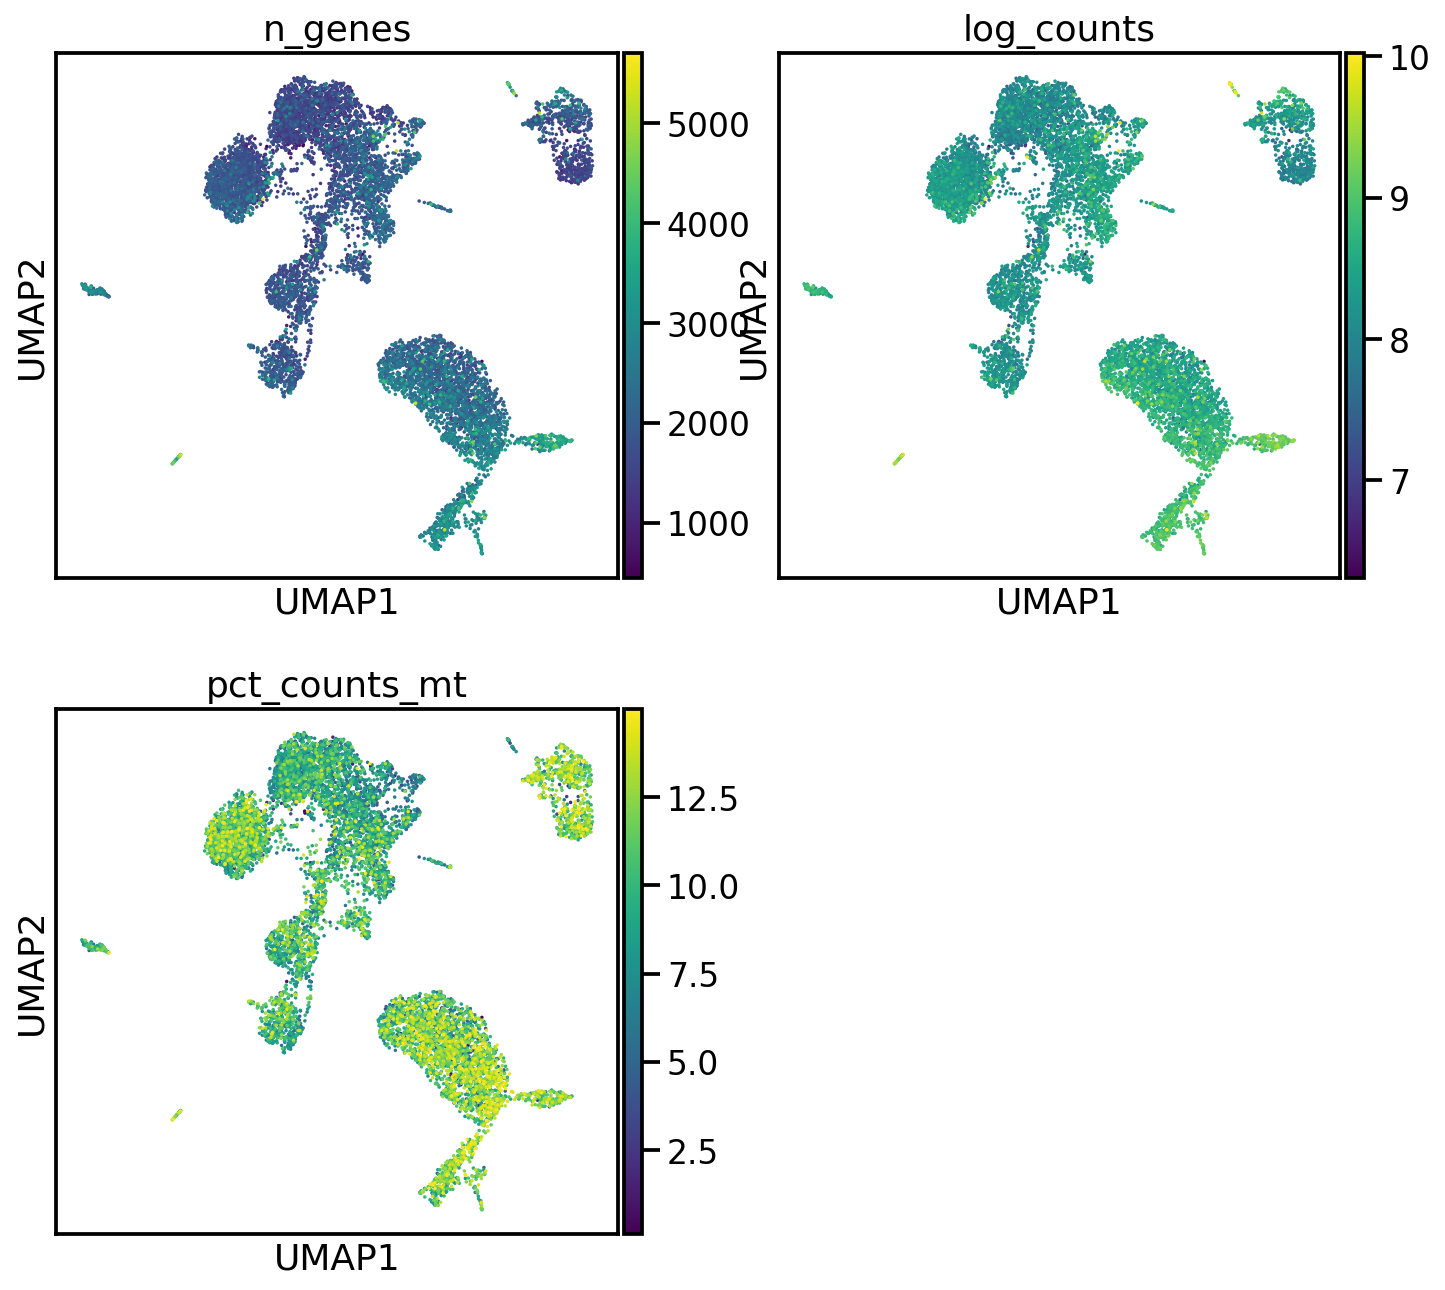

In [40]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
sc.pp.neighbors(rna, n_pcs=30,n_neighbors=10,random_state=42)
#bbknn.bbknn(rna,batch_key = "donnor", neighbors_within_batch =10, n_pcs = 50)
genes_to_plot = ['n_genes','log_counts','pct_counts_mt']
#sc.tl.tsne(rna, n_jobs=8,use_rep='X', perplexity=30) 
sc.tl.umap(rna,random_state=42)
savefig=samplename+"_4_QC_doublets_vst_mito.pdf"
sc.pl.umap(rna, color = genes_to_plot,ncols=2,save=savefig)

In [41]:
%%capture
sc.tl.leiden(rna,random_state=random_state,resolution=1.5, key_added='leiden_r1.5')
sc.tl.leiden(rna,random_state=random_state,resolution=1, key_added='leiden_r1')
sc.tl.leiden(rna,random_state=random_state, resolution=0.8, key_added='leiden_r0.8')
sc.tl.leiden(rna,random_state=random_state, resolution=0.5, key_added='leiden_r0.5')
sc.tl.leiden(rna,random_state=random_state, resolution=0.4, key_added='leiden_r0.4')
sc.tl.leiden(rna,random_state=random_state, resolution=0.3, key_added='leiden_r0.3')
sc.tl.leiden(rna,random_state=random_state, resolution=0.2, key_added='leiden_r0.2')

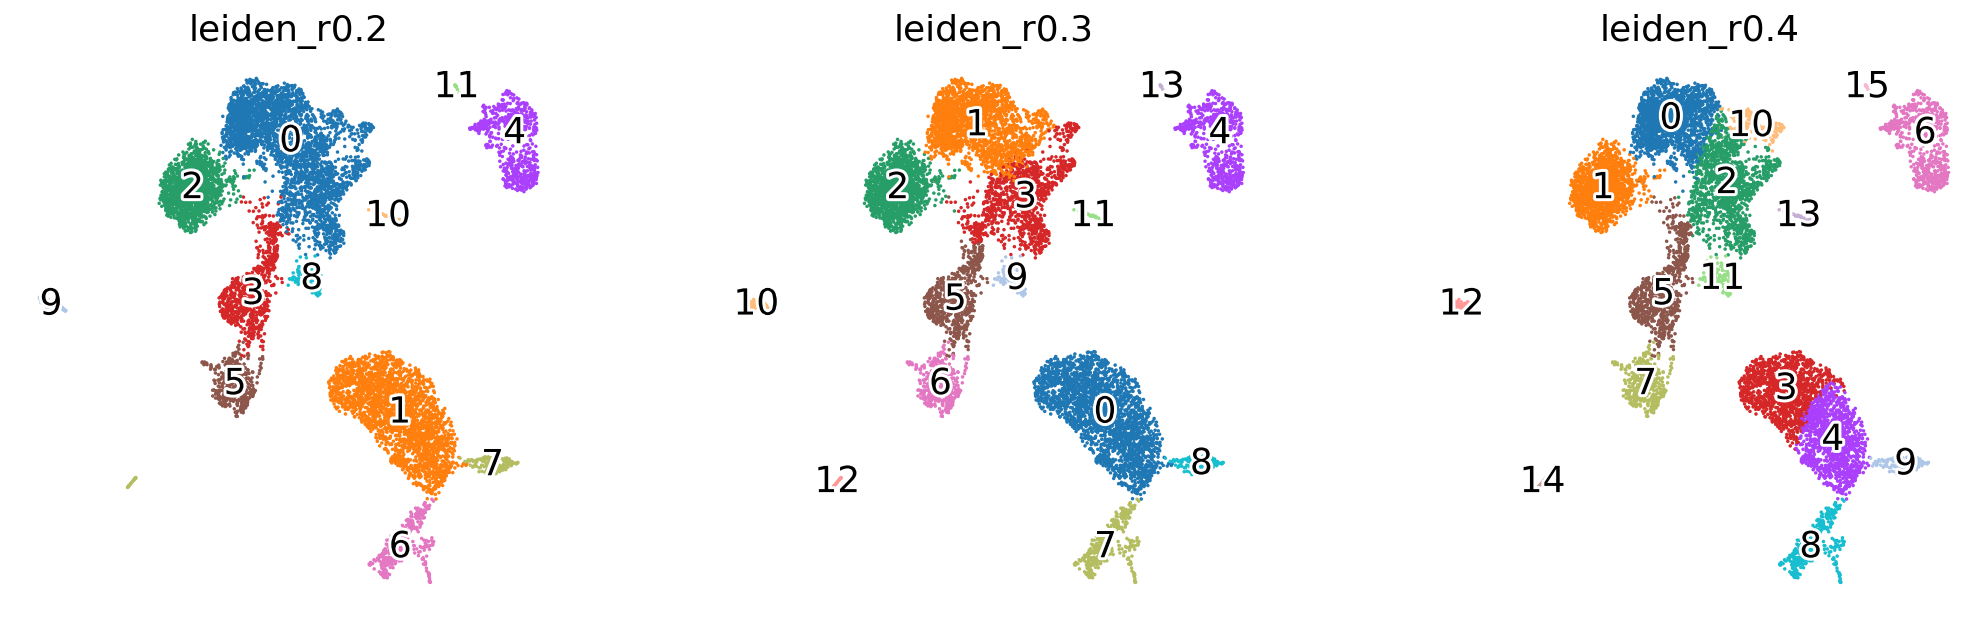

In [42]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
#sc.tl.leiden(rna,random_state=random_state, resolution = 0.5)
savefig=samplename+"_clustering_lores_vst.pdf"
sc.pl.umap(rna, color=['leiden_r0.2','leiden_r0.3','leiden_r0.4'], legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

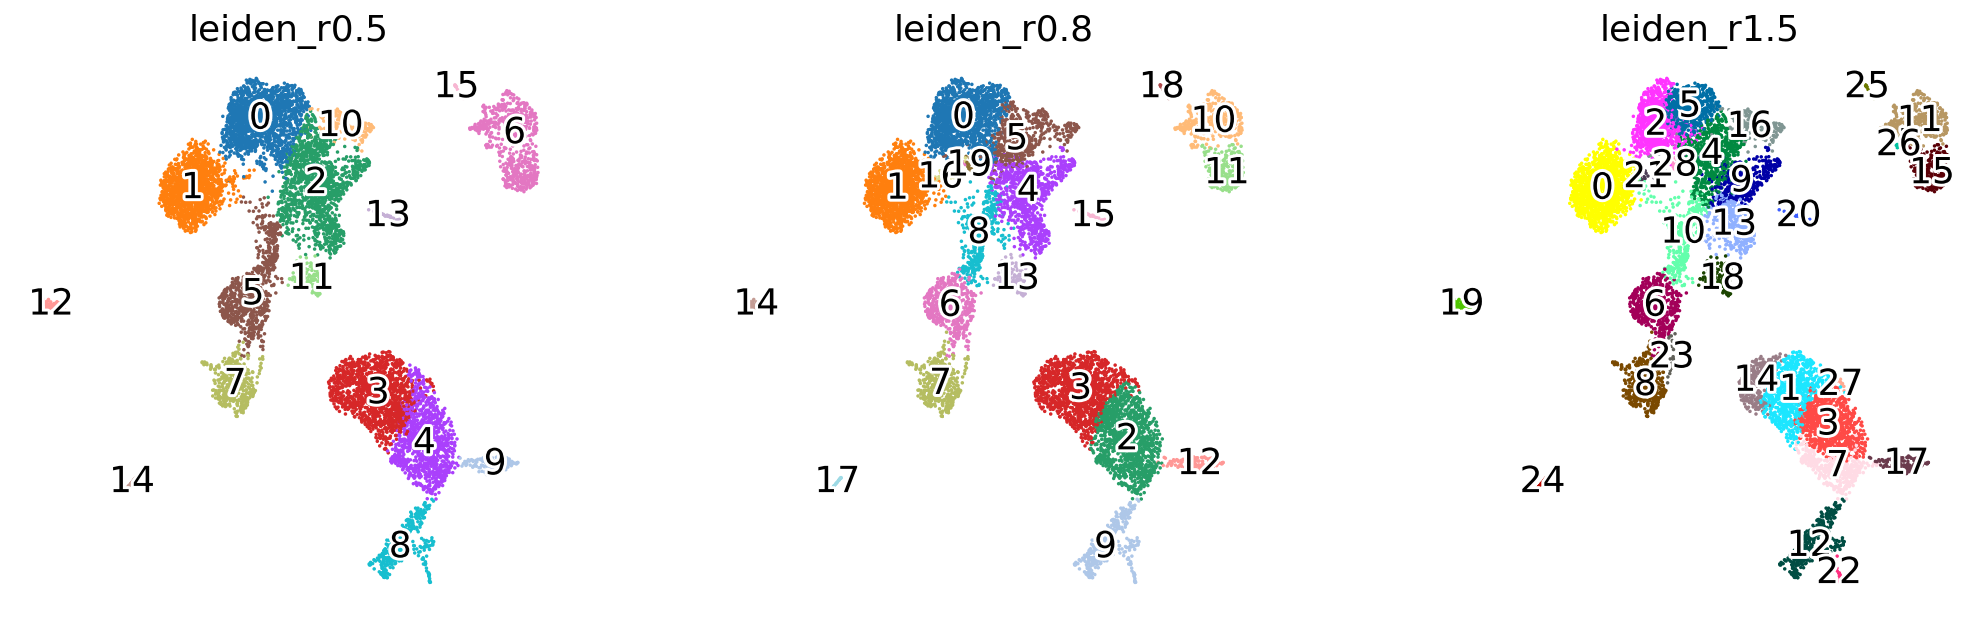

In [43]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
#sc.tl.leiden(rna,random_state=random_state, resolution = 0.5)
savefig=samplename+"_clustering_hires_vst.pdf"
sc.pl.umap(rna, color=['leiden_r0.5','leiden_r0.8','leiden_r1.5'], legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

In [44]:
sc.tl.paga(rna,groups='leiden_r0.5')
sc.pl.paga(rna, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(rna, init_pos='paga')

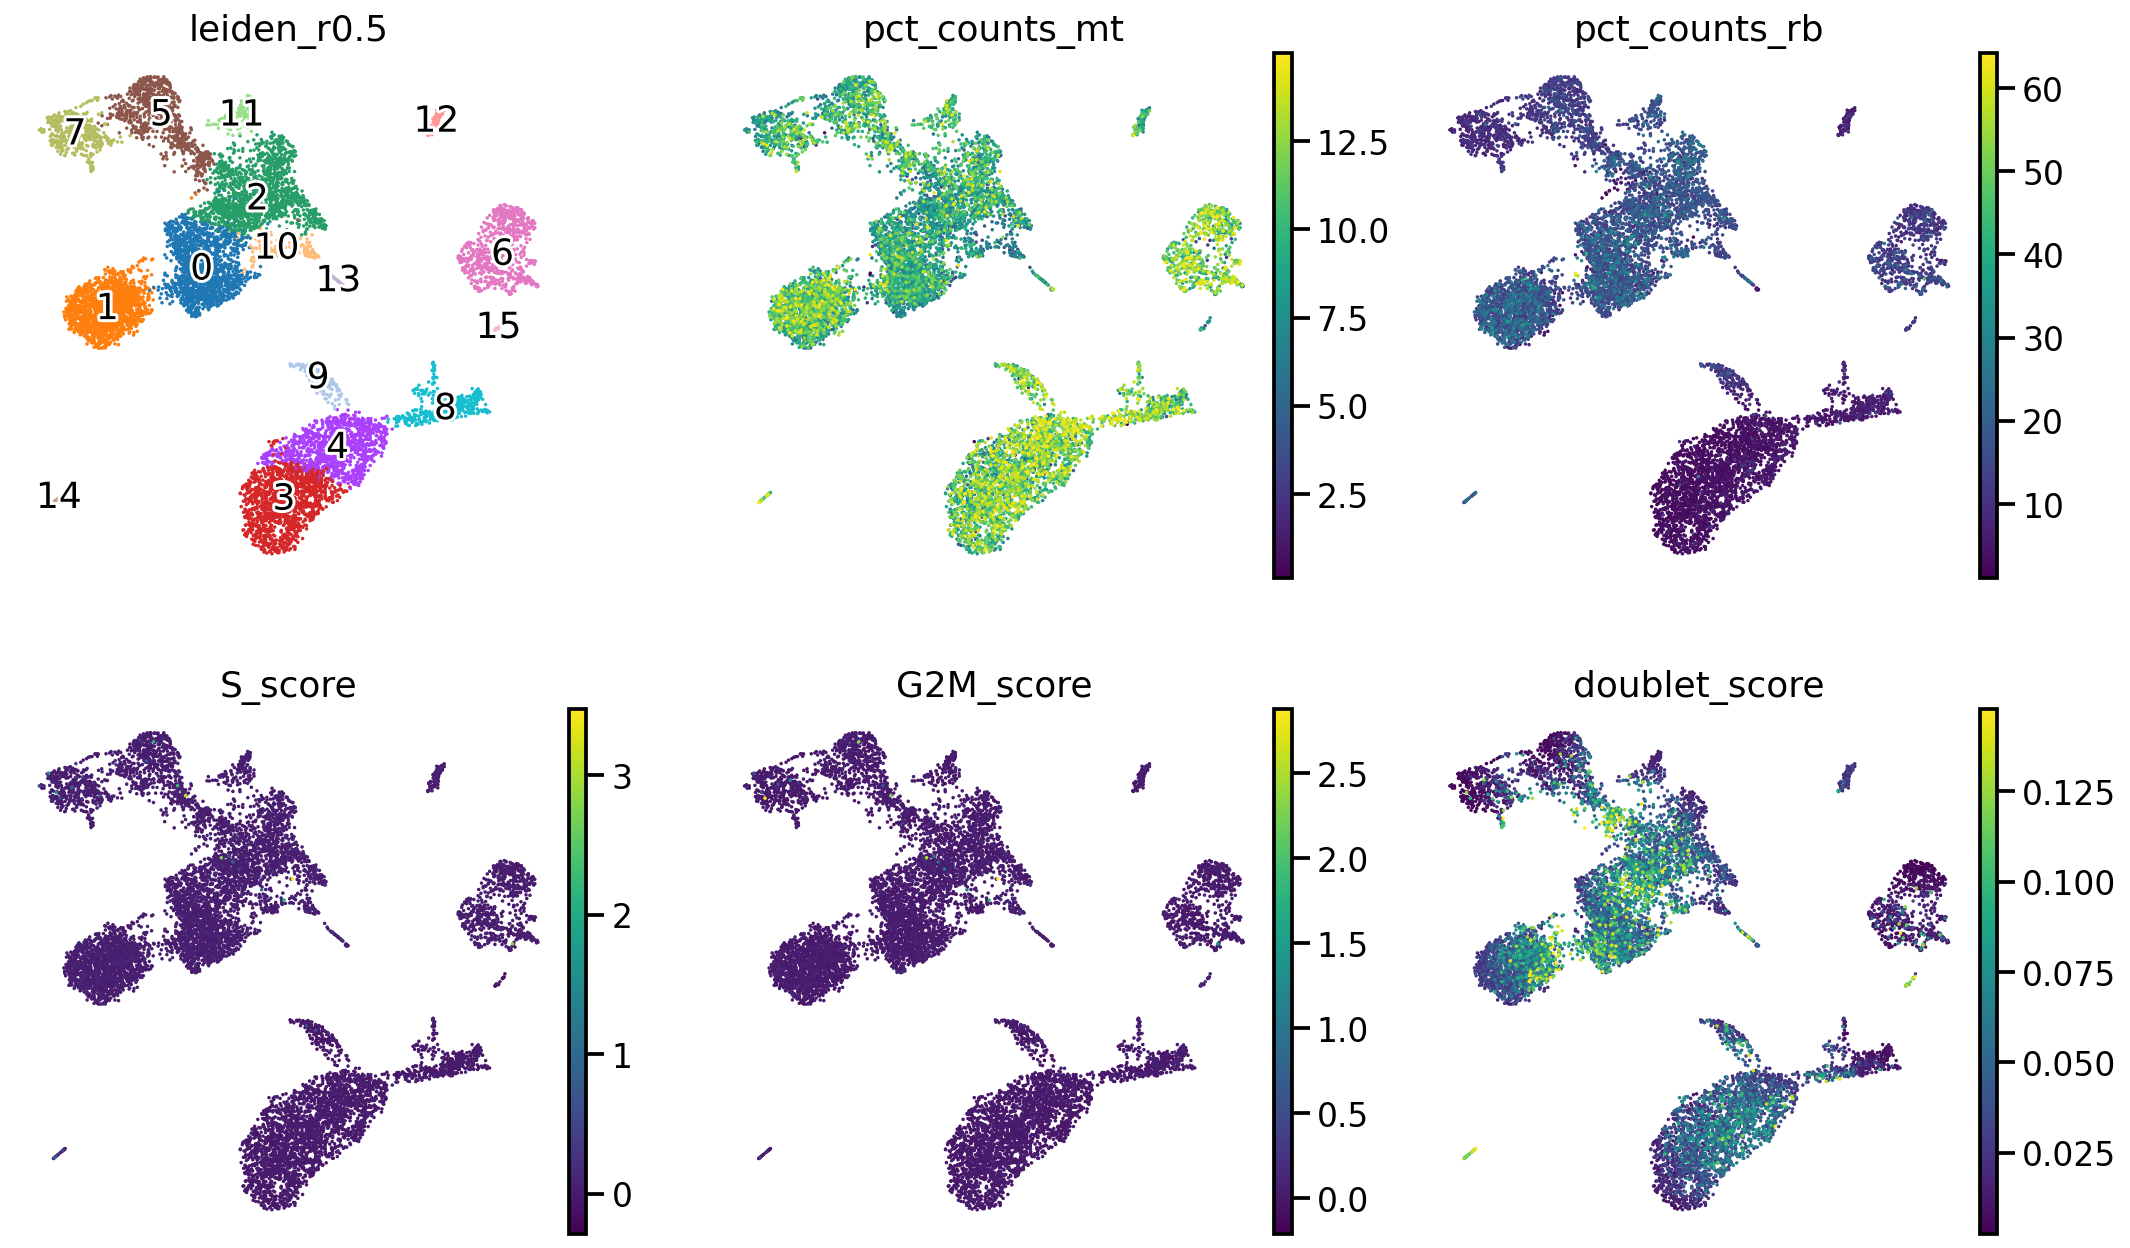

In [45]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
savefig=samplename+"_5_clustering_vst_lowres.pdf"
sc.pl.umap(rna, color=['leiden_r0.5','pct_counts_mt','pct_counts_rb','S_score','G2M_score','doublet_score'],ncols=3, legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

In [46]:
cluster='rna_cluster_clean.h5ad'
rna.write(cluster)

In [47]:
cluster='rna_cluster_clean.h5ad'
rna=sc.read(cluster)

# Marker genes

In [48]:
#method : {‘logreg’, ‘t-test’, ‘wilcoxon’, ‘t-test_overestim_var’} | None (default: None)
sc.tl.rank_genes_groups(rna, 'leiden_r0.5', method='t-test',n_genes=rna.shape[1])
markers=pd.DataFrame(rna.uns['rank_genes_groups']['names']).head(20)
markers

0        1         2         3         4       5          6  \
0         LEF1     LEF1    INPP4B    PLXDC2     NEAT1    CCL5      BANK1   
1       BCL11B    BACH2      IL32      VCAN      AOAH    NKG7       AFF3   
2         FHIT    PDE3B      ANK3      DPYD      DPYD    IL32       CD74   
3        CAMK4   THEMIS       LTB     NEAT1    SLC8A1   SYNE2    RALGPS2   
4        BACH2    NELL2      IL7R  ARHGAP26    PLXDC2    GZMA      MS4A1   
5         ANK3     CD8B    CDC14A     LRMDA      TYMP     A2M       PAX5   
6       INPP4B   BCL11B     SYNE2     CSF3R      SAT1   PRKCH    HLA-DRA   
7         TCF7   OXNAD1     ITGB1      FCN1      JAK2   SYNE1      FCRL1   
8         CCR7    CAMK4     RPS27      ZEB2      ZEB2    GNLY       IGHM   
9   AC139720.1     CCR7  ARHGAP15   DENND1A       LYN   SKAP1      CD79A   
10       PRKCA      TXK      RORA     RBM47   DENND1A   KLRG1  LINC00926   
11       MLLT3    APBA2    TTC39C      AOAH  ARHGAP26    GZMH       EBF1   
12         TXK   ABLIM1     RPL13     LRRK2      FCN1   SAMD3   HLA-DRB1   
13      OXNAD1     TCF7     RPL11       FOS     LRMDA     PZP        BLK   
14   LINC00861     CD8A    RPS27A     DOCK8      LYST  PYHIN1    OSBPL10   
15       TSHZ2    MAML2     RPL41      JAK2     DOCK8  TGFBR3   HLA-DQA1   
16        IL7R  SERINC5     RPS18      LYST     NAMPT    CST7      CD79B   
17       CD247     IL7R      RPL3     IRAK3     DMXL2    CTSW       CD22   
18     PIK3IP1   NDFIP1    RPL13A     NAMPT       FOS    PRF1     SEL1L3   
19     TRABD2A      ITK     RPL30      SAT1     MCTP1   KLRK1   ARHGAP24   

         7         8         9         10       11          12          13  \
0     GNLY      PSAP      CD74      IKZF2  SLC4A10        TCF4  AC105402.3   
1     NKG7    TCF7L2    SAMHD1      RTKN2     NKG7      FCHSD2         UTY   
2     PRF1       LYN       LYZ      SKAP1  PHACTR2        RHEX      RPS4Y1   
3    CD247      SAT1      CST3       IL32     RORA        CD74        PRKY   
4     GZMA     MTSS1   HLA-DRA      IL2RA    SYNE2        UGCG       PRKCA   
5    KLRD1      CTSS     HDAC9      SYNE2    KLRB1        IRF8       USP9Y   
6    MCTP2      CST3  HLA-DRB1       CASK      A2M        PLD4       DDX3Y   
7     CTSW      UTRN      ACTB        TOX     CCL5        AFF3       PLCL1   
8     CST7      WARS  HLA-DPA1     BCL11B     IL7R    RABGAP1L       TSHZ2   
9    SPON2      TYMP  HLA-DPB1       BCL2   ZBTB16       RUNX2     FAM118A   
10   KLRF1      CD74    PABPC1     ARID5B     GZMK        ZFAT       RPLP1   
11   SYNE1     COTL1  HLA-DQA1       TRAC     IL32      BCL11A         CD5   
12   PRKCH    IFITM3       VIM       ETS1     GZMA        CUX2       HLA-C   
13  PYHIN1      LYST  HLA-DQB1       TNIK     TC2N       PTPRS        DGKA   
14    GZMB  SERPINA1   CCDC88A      FOXP3    PLCB1      CCDC50      TMSB4X   
15    PFN1    FCGR3A     COTL1      PLCL1    SKAP1       PLAC8       CAMK4   
16  TGFBR3      AIF1      AFF3      PRKCH    KLRG1  AC023590.1        CHD2   
17    CCL5  TNFRSF1B       GRN  LINC02694     CTSW       EPHB1   LINC00278   
18   IL2RB      LST1      JAK2    SLFN12L   S100A4   LINC01374       RPS3A   
19     CD7    TBXAS1      FTH1      RPS26    PARP8      NIBAN3     ANKRD17   

         14        15  
0     RPS3A    TXNDC5  
1      CDK6  IFNG-AS1  
2    MT-ND1      SUB1  
3     RPLP0    UBE2J1  
4     RACK1      SSR4  
5      MSI2      MZB1  
6      SOX4    TENT5C  
7    RNF220     SPCS2  
8     RPL34     PDIA4  
9     RPS23     ITM2C  
10    RPL11      SSR2  
11   EEF1A1      XBP1  
12   MT-ND3      PPIB  
13     XIST    SEC61B  
14    RPS4X    ZNF706  
15     LDHB      GNG7  
16    ZNRF1   HSP90B1  
17   MT-ND2     ISG20  
18  ATP5MC2     MEF2C  
19    RPL28      CD74

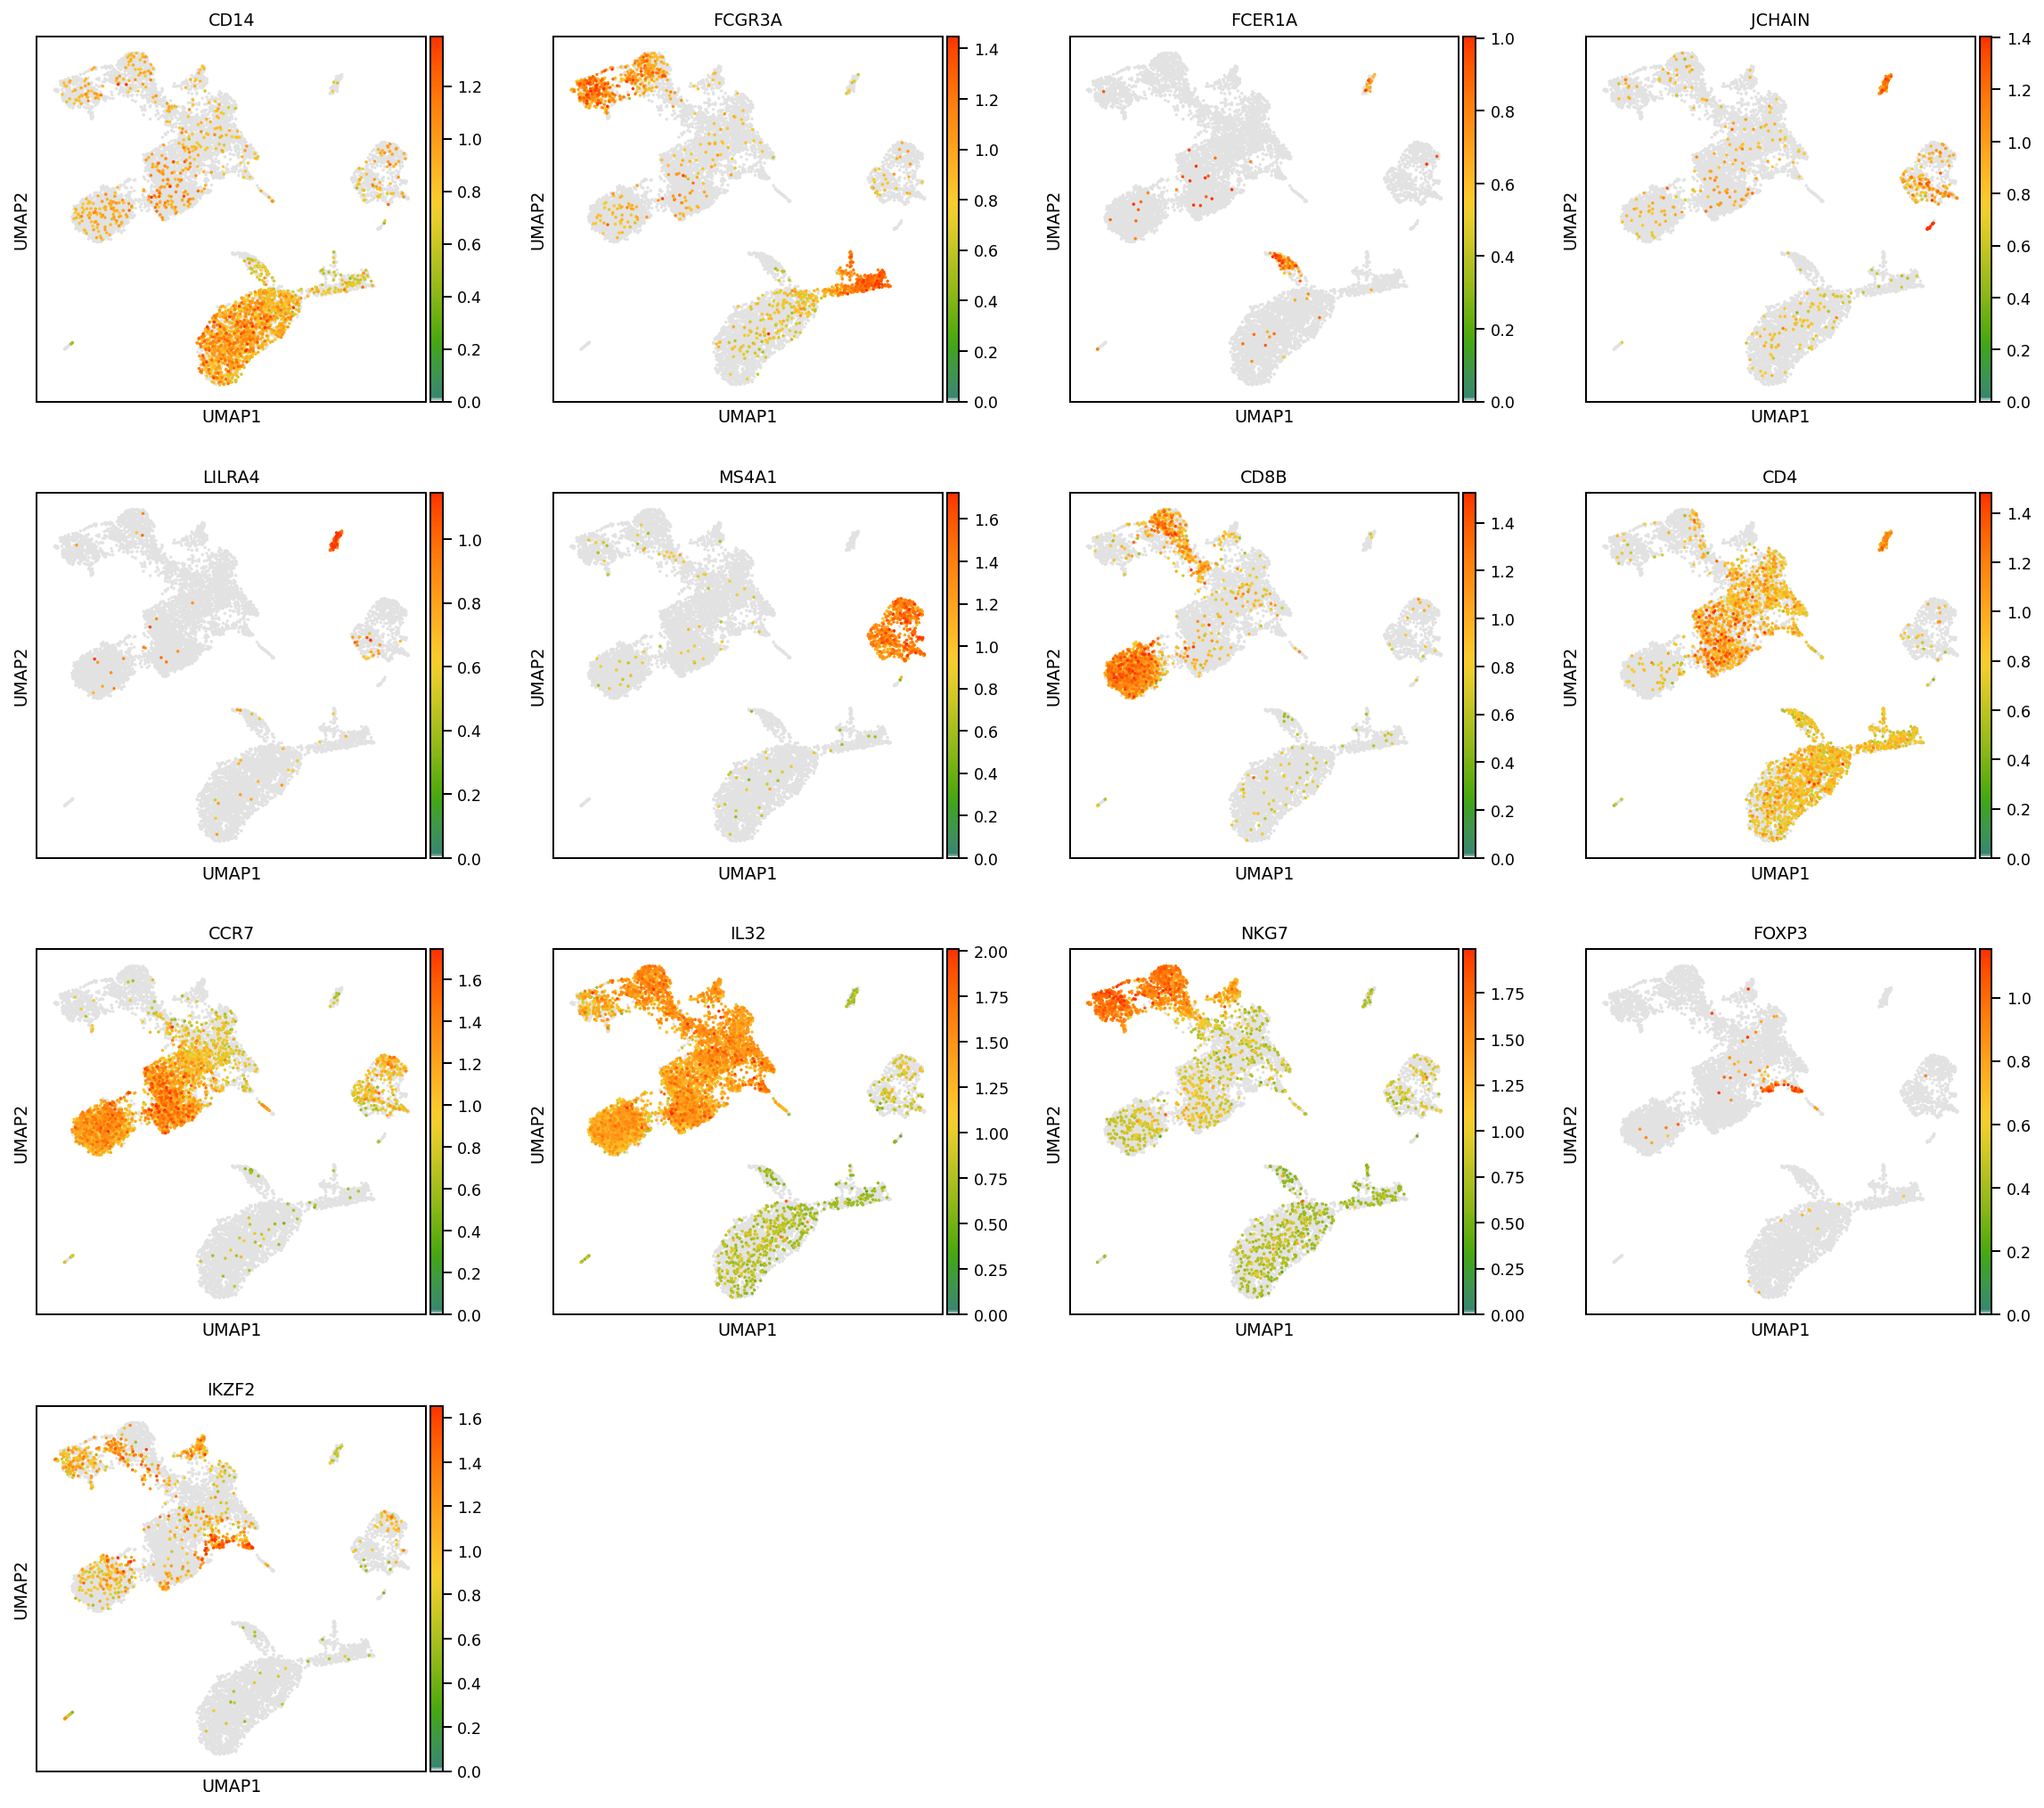

In [49]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(4,4) #rescale figures
savefig=samplename+"_10_markers_1.pdf"
sc.pl.umap(adata=rna, color=['CD14','FCGR3A','FCER1A','JCHAIN','LILRA4','MS4A1','CD8B','CD4','CCR7','IL32','NKG7','FOXP3','IKZF2'],color_map=mymap,vmin='p20', vmax='p99.9',ncols=4,
           legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',use_raw=False,layer="sqrt_norm", save=savefig)

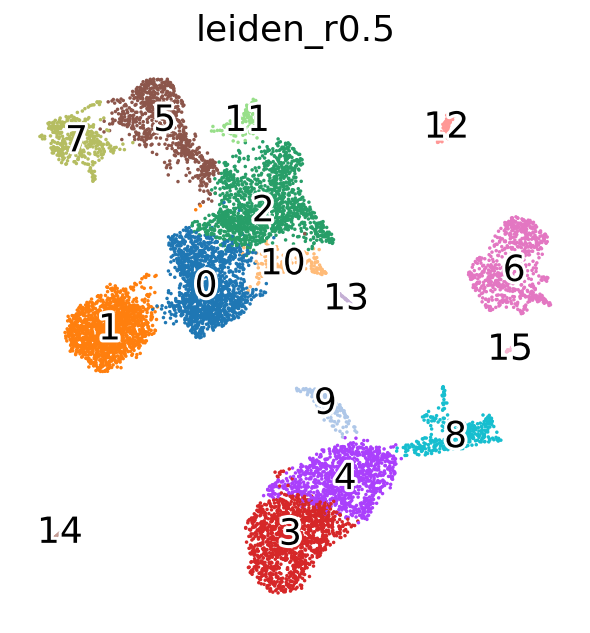

In [50]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
savefig=samplename+"_5_clustering_vst_lowres.pdf"
sc.pl.umap(rna, color=['leiden_r0.5'],ncols=3, legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

# Annotation

In [51]:
rna.obs['annotated'] = rna.obs['leiden_r0.5'].cat.add_categories([ "CD4+ memory T", "CD8+ naïve T", "CD4+ naïve T", "CD8+ activated T", "NK",  "MAIT",'Tregs',
                                                                  "memory B", "naïve B","CD14 mono", "intermediate mono", "CD16 mono","mDC", "pDC",])
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['3'])] = 'CD4+ memory T'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['0','14','13'])] = 'CD4+ naïve T'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['1'])] = 'CD8+ naïve T'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['10'])] = 'Tregs'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['11'])] = 'MAIT'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['6',])] = 'CD8+ activated T'
#rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['7'])] = 'memory B'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['5'])] = 'naïve B'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['7'])] = 'NK'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['2'])] = 'CD14 mono'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['4'])] = 'intermediate mono'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['8'])] = 'CD16 mono'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['9'])] = "mDC"
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['12'])] = "pDC"

rna.obs['annotated'] = rna.obs['annotated'].cat.remove_unused_categories()

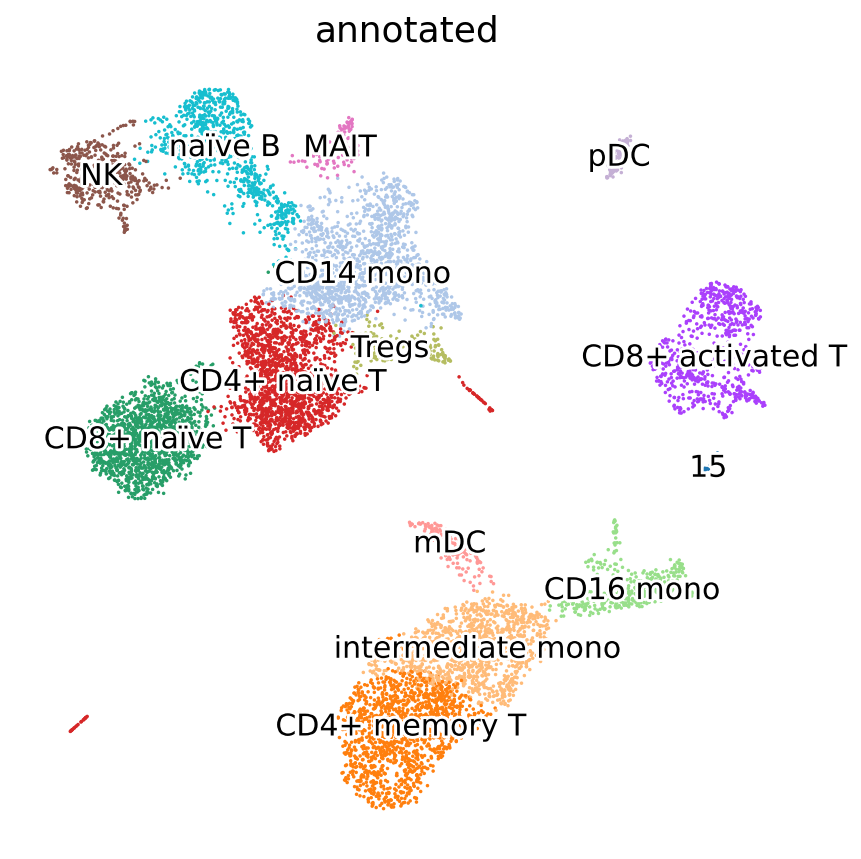

In [52]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(7,7)
#sc.tl.leiden(adata,random_state=random_state, resolution = 0.5)
savefig=samplename+"_annotated_hires_annotated.pdf"
sc.pl.umap(rna, color=['annotated'], legend_loc='on data',cmap=mymap,legend_fontoutline=3,vmax='p99.9',legend_fontsize='small', legend_fontweight='normal',frameon=False,save=savefig)

#sample composition

In [53]:
order=rna.obs['annotated'].value_counts()

In [54]:
order.index

CategoricalIndex(['CD4+ naïve T', 'CD8+ naïve T', 'CD14 mono', 'CD4+ memory T',
                  'intermediate mono', 'naïve B', 'CD8+ activated T', 'NK',
                  'CD16 mono', 'mDC', 'Tregs', 'MAIT', 'pDC', '15'],
                 categories=['15', 'CD4+ memory T', 'CD8+ naïve T', 'CD4+ naïve T', 'CD8+ activated T', 'NK', 'MAIT', 'Tregs', ...], ordered=False, dtype='category')

In [55]:
rna.obs['annotated'].cat.categories

Index(['15', 'CD4+ memory T', 'CD8+ naïve T', 'CD4+ naïve T',
       'CD8+ activated T', 'NK', 'MAIT', 'Tregs', 'naïve B', 'CD14 mono',
       'intermediate mono', 'CD16 mono', 'mDC', 'pDC'],
      dtype='object')

In [57]:
print(rna.obs['annotated'].value_counts())

CD4+ naïve T         1659
CD8+ naïve T         1466
CD14 mono            1408
CD4+ memory T        1334
intermediate mono    1106
naïve B               761
CD8+ activated T      658
NK                    423
CD16 mono             380
mDC                   161
Tregs                 148
MAIT                  123
pDC                    94
15                     17
Name: annotated, dtype: int64


In [58]:
order=rna.obs['annotated'].value_counts()

In [59]:
order.index

CategoricalIndex(['CD4+ naïve T', 'CD8+ naïve T', 'CD14 mono', 'CD4+ memory T',
                  'intermediate mono', 'naïve B', 'CD8+ activated T', 'NK',
                  'CD16 mono', 'mDC', 'Tregs', 'MAIT', 'pDC', '15'],
                 categories=['15', 'CD4+ memory T', 'CD8+ naïve T', 'CD4+ naïve T', 'CD8+ activated T', 'NK', 'MAIT', 'Tregs', ...], ordered=False, dtype='category')

# Save the results

In [60]:
pwd

'/home/jovyan/work/multiomics'

In [61]:
mdata.mod['rna']=rna

In [64]:
mdata.write("pbmc10k.h5mu")

... storing 'sample' as categorical
... storing 'group' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'interval' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


In [65]:
rna

AnnData object with n_obs × n_vars = 9738 × 22020
    obs: 'sample', 'group', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'doublet_score', 'predicted_doublet', 'QC', 'S_score', 'G2M_score', 'phase', 'leiden_r1.5', 'leiden_r1', 'leiden_r0.8', 'leiden_r0.5', 'leiden_r0.4', 'leiden_r0.3', 'leiden_r0.2', 'annotated'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'group_colors', 'hvg', 'leiden', 'leiden_r0.2_colors', 'leiden_r0.3_colors', 'leiden_r0.4_colors', 'leiden_r0.5_colors', 'leiden_r0.5_sizes', 'leiden_r0.8_colors', 'leiden_r1.5_colors', 'neighbors', 'paga', 'pca', 'pearson_residuals_normalization', 'scrublet', 'umap', 'rank_genes_groups', 'annotated_colors'
    obsm: 'X_pca', '

In [66]:
mdata

MuData object with n_obs × n_vars = 11909 × 130397
  obs:	'sample', 'group'
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	9738 x 22020
      obs:	'sample', 'group', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'doublet_score', 'predicted_doublet', 'QC', 'S_score', 'G2M_score', 'phase', 'leiden_r1.5', 'leiden_r1', 'leiden_r0.8', 'leiden_r0.5', 'leiden_r0.4', 'leiden_r0.3', 'leiden_r0.2', 'annotated'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
      uns:	'group_colors', 'hvg', 'leiden', 'leiden_r0.2_colors', 'leiden_r0.3_colors', 'leiden_r0.4_colors', 'leiden_r0.5_colors', 'leiden_r0.5_sizes', 'leiden_r0.8_colors', 'leiden_r1.5_colors', 'neighbors', 'paga', 'pca', 'pearson_residuals_normalization', 'scrublet', 'umap', 'rank_genes_groups', 'annotated_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'logcounts', 'normalized', 'raw', 'sqrt_norm'
      obsp:	'connectivities', 'distances'
    atac:	11909 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

In [67]:
rna = rna[:, rna.var.highly_variable]
rna

View of AnnData object with n_obs × n_vars = 9738 × 3000
    obs: 'sample', 'group', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'doublet_score', 'predicted_doublet', 'QC', 'S_score', 'G2M_score', 'phase', 'leiden_r1.5', 'leiden_r1', 'leiden_r0.8', 'leiden_r0.5', 'leiden_r0.4', 'leiden_r0.3', 'leiden_r0.2', 'annotated'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'group_colors', 'hvg', 'leiden', 'leiden_r0.2_colors', 'leiden_r0.3_colors', 'leiden_r0.4_colors', 'leiden_r0.5_colors', 'leiden_r0.5_sizes', 'leiden_r0.8_colors', 'leiden_r1.5_colors', 'neighbors', 'paga', 'pca', 'pearson_residuals_normalization', 'scrublet', 'umap', 'rank_genes_groups', 'annotated_colors'
    obsm: 'X_

In [68]:
rna.X=rna.X.todense()

In [69]:
#%%capture
predict_cell_types(rna,cluster_key='leiden_r0.5',obs_out_key='predicted',species='human',ref_label_column='label.main')

NameError: name 'predict_cell_types' is not defined

In [ ]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(10,10)
umap_point_size = np.maximum(120000/rna.n_obs, 2)
#sc.tl.leiden(rna,random_state=random_state, resolution = 0.5)
#savefig=samplename+"_6_predicted.pdf"
sc.pl.umap(rna, color=['predicted'], legend_loc='on data',legend_fontoutline=3,vmin='p10', vmax='p99.9',cmap=mymap, legend_fontweight='normal',size=umap_point_size,frameon=False)

# Search for genes

In [ ]:
regex = re.compile('^(PTPRC).*', re.IGNORECASE)
genes = [l for l in rna.var_names for m in [regex.search(l)] if m]

In [ ]:
genes

In [ ]:
mdata.mod['rna'] = rna

In [ ]:
pwd